<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#подготовка-данных-к-обучению" data-toc-modified-id="подготовка-данных-к-обучению-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>подготовка данных к обучению</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

## Подготовка

In [2]:
data=None
try:
    data=pd.read_csv('/datasets/taxi.csv')
    display(data.head())
except:
    print('Something went wrong')

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


как мы увидели выше, столбец "datetime" хранит в себе конкретное время, а его тип данных - object, что не правильно, стоит привести этот столбец к типу DateTime

In [4]:
data['datetime']= pd.to_datetime(data['datetime'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


поскольку столбец num_orders показывает кол-во заказов за последние 10 минут, это значение может быть только int, что мы и видим, так что со стороны типов данных, эта таблица чиста.

проверим данные на пропуски. Это важно, поскольку на вход модели могут поступать только признаки не имеющие пропущенных значений. 

In [5]:
print(data.isna().sum())

datetime      0
num_orders    0
dtype: int64


пропусков нет, что очень хорошо, можем переходить к проверке на дубликаты (явные и неявные), но для начала явные:

In [6]:
print(data.duplicated().sum())

0


отлично, явных дубликатов у нас нет, но стоит проверить нет ли дубликатов среди моментов времени, поскольку у нас не может быть такого, что один и тот же момент времени наступил несколько раз и выдал разные значения. 

In [7]:
print(data['datetime'].duplicated().sum())

0


отлично! Дубликатов нет. Данные чисты. Теперь, поскольку у нас предоставляются данные по моментам времени, мы должны будем анализировать временной ряд, но для этого данные должны быть разбиты на равные промежутки времени, проверим, так ли это. Как можно заметить по выведенным данным, временной шаг составляет 10 минут, проверим так ли это на всем промежутке.  

In [8]:
last_val=data.iloc[0]['datetime'].minute
new_val=0
count=1
for i in range (1, len(data['datetime'].unique())):
    new_val=data.iloc[i]['datetime'].minute
    if not(new_val-last_val==10 or last_val-new_val==50 and count==6):
        print(last_val,new_val, i, count,'NO')
        break
    if count==6:
        count=0
    count+=1
    last_val=new_val

Поскольку ничего не вывелось, можно сказать, что шаг всегда один и тот же (10 минут)
но стоит понимать,что мы анализировали только минуты, стоит еще проверить, действительно ли данные расположены в хронологическом порядке.

In [9]:
print(data.index.is_monotonic)

True


Данные расположены в хронологическом порядке. 
Так что можного говорить, что данные проверены, подготовим их к дальнейшему анализу (то есть индексами сделаем время) 

In [10]:
data=data.set_index('datetime')
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


все готово, можно преступать к анализу.

**Вывод по данному этапу** На этапе подготовки мы загрузили данные, изменили формат данных столбца datetime и проверили, что данные не иммеют дубликатов, пропусков и равномерно распределены на временной оси. 

## Анализ

построим график временного ряда.

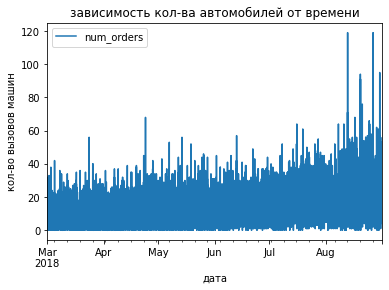

In [11]:
data.plot()
plt.title('зависимость кол-ва автомобилей от времени')
plt.xlabel('дата')
plt.ylabel('кол-во вызовов машин');

такой график весьма не информативен, так что проведем ресемплирование по крайней мере по дням, поскольку у нас используются данные за несколько месяцев

In [12]:
new_data=data.resample('1D').sum()

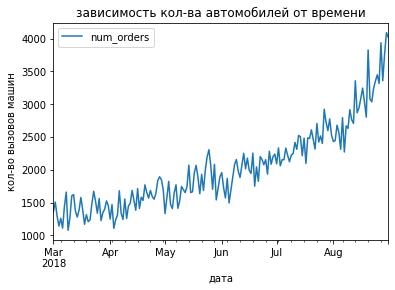

In [13]:
new_data.plot()
plt.title('зависимость кол-ва автомобилей от времени')
plt.xlabel('дата')
plt.ylabel('кол-во вызовов машин');

по данному графику видно, что в основном количество вызванных автомобилей за день растет, так что можно сказать что временной ряд у нас не стационарный, но мы так же видим колебания значений на данном графике, сгладим его

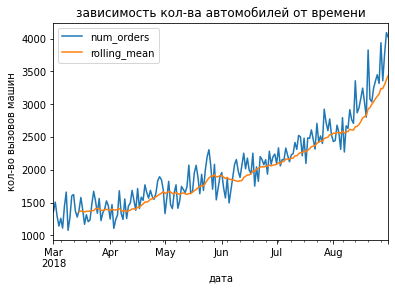

In [14]:
new_data['rolling_mean'] = new_data.rolling(15).mean()
new_data.plot()
plt.title('зависимость кол-ва автомобилей от времени')
plt.xlabel('дата')
plt.ylabel('кол-во вызовов машин');

как мы видим по оранжевой линии, количество вызванных автомобилей действительно постепенно возрастает.
так же мы можем отметить, что у наших данных нет глобальной сезонности (но это мы еще проверим ниже), поскольку значения практически постоянно растут, но зато можно сказать, что данные имеют тренд в увеличении количества заказов автомобилей вне зависимости от месяца/времени года и т.д

К тому же стоит отметить, что скользящее среднне отражает практически прямую, так что есть больлшая вероятность, что для этой задачи может подойти обыкновенная линейная модель.

посмотрим на сезонность и тренд на графиках.

In [15]:
decomp=seasonal_decompose(new_data['num_orders']) 

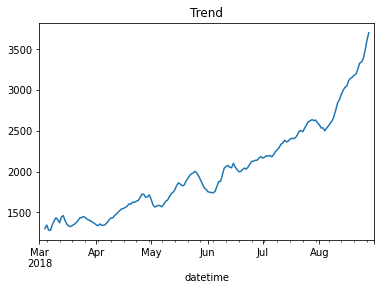

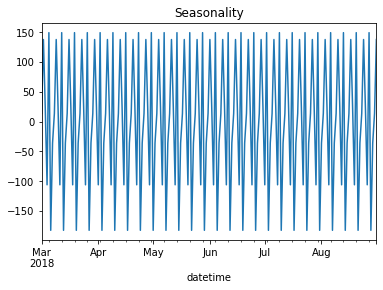

In [16]:
decomp.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.show()
decomp.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.show()

как мы видим, на этом графике сложно определить сезонность, попробуем ее рассмотреть на более маленьком промежутке, потому что есть вероятность, что она зависит от дня недели, поскольку в какие-то дни могут летать более популя
рные рейсы.
*чтобы не засорять память, удалим new_data*

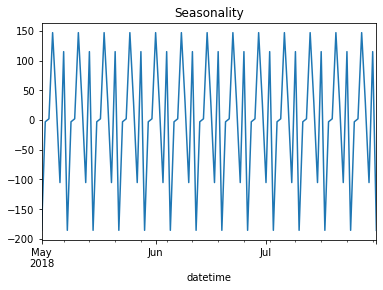

In [17]:
new_decomp=seasonal_decompose(data.resample('1D').sum()['2018-05':'2018-07']) 
new_decomp.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.show()

как мы видим временная ось разделена на 4 с небольшим отрезков, что в реальности соответствует неделям, то есть, можно сделать вывод о том, что в начале недели у нас заказы резко падают, то есть прилетают самолеты с не самых популярных рейсов, после чего кол-во вызовов возрастает, то есть делаем вывод о том, что данные у нас зависят от дня недели.

In [18]:
del new_data
del decomp

**вывод по этапу.** На данном этапе мы проанализировали наш временной ряд, поняли, что он имеет тренд в росте количества вызванных автомобилей, но этот параметр не имеет сезонности, то есть по нашим данным нельзя сказать, зависит ли он от времени года, поскольку нам предоставлено слишком мало данных.

## подготовка данных к обучению

перейдем к процесу обучения моделей для прогнозирования, то есть решения задачи прогнозирования временного ряда (регрессия). 

Поскольку заказчику важно, чтобы мы проводили прогноз на час, нужно будет провести ресемплирование признаков

In [19]:
data=data.resample('1H').sum()
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Поскольку в нашем датасете есть только результаты, нужно получить и признаки, так что займемся созданием признаков из индексов (каленарные признаки), значения предудущих часов и значения скользящего среднего, показывающий общий тренд временного ряда.  

1. введем календарные признаки:  день, месяц и день недели, как мы выяснили выше важный признак.

In [20]:
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
display(data.head())

,num_orders,month,day,dayofweek
datetime,,,,
2018-03-01 00:00:00,124,3,1,3
2018-03-01 01:00:00,85,3,1,3
2018-03-01 02:00:00,71,3,1,3
2018-03-01 03:00:00,66,3,1,3
2018-03-01 04:00:00,43,3,1,3


2.  значения предудущих часов, мы будем брать информацию за прошедшие сутки ( то есть 24 часа), поскольку нам особо важно, что было в это же время но сутки назад и как изменялись показатели за это время.

In [21]:
for lag in range(1, 24 + 1):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
display(data.head(10))

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,1,3,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,1,3,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3. значения скользящего среднего

In [22]:
data['rolling_mean'] = data['num_orders'].shift().rolling(5).mean()
display(data.head(10))

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.8
2018-03-01 06:00:00,12,3,1,3,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.2
2018-03-01 07:00:00,15,3,1,3,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.6
2018-03-01 08:00:00,34,3,1,3,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.4


посмтрим на типы данных

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int64  
 2   day           4416 non-null   int64  
 3   dayofweek     4416 non-null   int64  
 4   lag_1         4415 non-null   float64
 5   lag_2         4414 non-null   float64
 6   lag_3         4413 non-null   float64
 7   lag_4         4412 non-null   float64
 8   lag_5         4411 non-null   float64
 9   lag_6         4410 non-null   float64
 10  lag_7         4409 non-null   float64
 11  lag_8         4408 non-null   float64
 12  lag_9         4407 non-null   float64
 13  lag_10        4406 non-null   float64
 14  lag_11        4405 non-null   float64
 15  lag_12        4404 non-null   float64
 16  lag_13        4403 non-null   float64
 17  lag_14        4402 non-null

отметим, что в столбце num_orders у нас хранятся целочисленные значения, а поскольку мы переносим эти данные со сдвигом в столбцы lag_1, lag_2,..., lag_24 в этих столбцах тоже должен быть тип int64, но поскольку в нашем датасете появились nan их надо удалить, чтобы была возможность обучить модель, не наткнувшись на ошибку, после чего займемся преобразованием типов данных

In [24]:
data=data.dropna()
print(data.isna().sum())
display(data.head(10))

num_orders      0
month           0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64


,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,68.6
2018-03-02 01:00:00,120,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,77.6
2018-03-02 02:00:00,75,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,89.4
2018-03-02 03:00:00,64,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,91.2
2018-03-02 04:00:00,20,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,81.4
2018-03-02 05:00:00,11,3,2,4,20.0,64.0,75.0,120.0,90.0,58.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,73.8
2018-03-02 06:00:00,11,3,2,4,11.0,20.0,64.0,75.0,120.0,90.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,58.0
2018-03-02 07:00:00,7,3,2,4,11.0,11.0,20.0,64.0,75.0,120.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,36.2
2018-03-02 08:00:00,46,3,2,4,7.0,11.0,11.0,20.0,64.0,75.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,22.6


In [25]:
for i in range(1, 25):
    data['lag_{}'.format(i)]=data['lag_{}'.format(i)].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   month         4392 non-null   int64  
 2   day           4392 non-null   int64  
 3   dayofweek     4392 non-null   int64  
 4   lag_1         4392 non-null   int64  
 5   lag_2         4392 non-null   int64  
 6   lag_3         4392 non-null   int64  
 7   lag_4         4392 non-null   int64  
 8   lag_5         4392 non-null   int64  
 9   lag_6         4392 non-null   int64  
 10  lag_7         4392 non-null   int64  
 11  lag_8         4392 non-null   int64  
 12  lag_9         4392 non-null   int64  
 13  lag_10        4392 non-null   int64  
 14  lag_11        4392 non-null   int64  
 15  lag_12        4392 non-null   int64  
 16  lag_13        4392 non-null   int64  
 17  lag_14        4392 non-null

удалились только первые 5 строк, теперь у нас есть признаки, так что можно разбивать данные на выборки.

In [26]:
targets=data['num_orders']
values=data.drop('num_orders', axis=1)

In [27]:
X_train, X_test, y_train, y_test= train_test_split(values, targets, shuffle=False, test_size=0.1)
print('начальный и конечный индексы обучающей выборки:', X_train.index.min(), X_train.index.max())
print('начальный и конечный индексы тестовой выборки:',X_test.index.min(), X_test.index.max())

начальный и конечный индексы обучающей выборки: 2018-03-02 00:00:00 2018-08-13 15:00:00
начальный и конечный индексы тестовой выборки: 2018-08-13 16:00:00 2018-08-31 23:00:00


теперь данные готовы к обучению.

**Вывод по данному этапу:** на данном этапе мы создали признаки, на которых будем обучать нашу модель, поняли, что анализироваьт нужно не каждые 10 минут, а по часам, поскольку заказчику нужны часы, и разделили выборку на обучающую и тестовую.

## Обучение

**прежде всего стоит отмметить, что оценивать модели на этапе обучения мы будем с помощью кросс-валидации, после чего выберем лучшую, обучим и передадим на этап тестирования**

Поскольку нам предстоит работать с несколькими моделями, напишем функцию, которая будет выводить результат кросс-валидации для переданной в нее модели.

In [28]:
def cross_val_model(model, X_train=X_train, y_train=y_train):
    tscv = TimeSeriesSplit()
    scores= cross_val_score(model, X_train, y_train, cv=tscv, scoring= 'neg_root_mean_squared_error')
    print('for {} RMSE = {}'.format(model, -1*sum(scores)/len(scores)))

прежде всего ознакомимся с линейной моделью.

In [29]:
linear_model=LinearRegression()
cross_val_model(linear_model)

for LinearRegression() RMSE = 27.02679869295489


как мы видим RMSE получился очень даже неплохой, но стоит учитывать, что на этапе тестирования немного данные имеют только тренд в росте (преимущественно), в отличии от обучающей, так что там качество будет ниже, так что рассмотрим еще и другие модели и выберем лучшую, хотя есть и большая вероятность, что эта модель покажет хороший результат на этапе тестирования.

In [30]:
tree_0_model=DecisionTreeRegressor(random_state=15684)
cross_val_model(tree_0_model)

for DecisionTreeRegressor(random_state=15684) RMSE = 36.97645385206049


как мы видим без подбора гиперпараметров наша модель показала слишком плохой результат по сравнению с предыдущей и вряд ли нам удасться достичь хотя бы такого же результата здесь, так что перейдем к модели случайного леса.

In [31]:
forest_0_model=RandomForestRegressor(random_state=87456)
cross_val_model(forest_0_model)

for RandomForestRegressor(random_state=87456) RMSE = 25.65598871218893


Эта модель без учета гипер параметров уже выдала достаточно неплохой резульат, так что постараемся улучшить ее качества за счет их подбора.

**ПРОСЬБА НЕ ОБРАЩАТЬ ВНИМАЕ НА ТО, ЧТО ВЫВОДИТСЯ ПОМИМО ИТОГА ПРИ ПОДБОРЕ ГИПЕРПАРАМЕТРОВ, ЭТО СДЕЛАНО ДЛЯ ТОГО, ЧТОБЫ ОТСЕЖИВАТЬ, ЧТО НИЧЕГО НЕ УПАЛО**

In [38]:
best_score=5000
best_estimator_forest=0
best_depth_forest=0
best_model=None
tscv = TimeSeriesSplit()
for estimator in range(1, 201, 20):
    print(estimator)
    for depth in range(10, 102, 10):
        forest_model=RandomForestRegressor(n_estimators=estimator, max_depth=depth, random_state=8745610)
        scores = cross_val_score(forest_model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
        final_score=-1*sum(scores)/len(scores)
        
        if final_score < best_score:
            best_score=final_score
            best_estimator_forest=estimator
            best_depth_forest=depth
            best_model=forest_model
print('The best model is {} and its RMSE is {}'.format(best_model, best_score))

1
21
41
61
81
101
121
141
161
181
The best model is RandomForestRegressor(max_depth=20, n_estimators=101, random_state=8745610) and its RMSE is 25.60743459643094


Теперь воспользуемся одним из самых популярных методов- градиенттным бустингом, причем сразу перейдем к подбору гиперпараметров

In [45]:
best_score=5000
best_estimator=0
best_depth_LGBM=0
best_model=None
for estimator  in range (11, 201, 10):
    for depth in range(5, 22, 2):
        forest_model=LGBMRegressor(n_estimators =estimator , max_depth=depth, random_state=12713)
        scores = cross_val_score(forest_model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
        final_score=-1*sum(scores)/len(scores)
        print(final_score, best_score)
        
        if final_score < best_score:
            best_score=final_score
            best_estimator=estimator
            best_depth_LGBM=depth
            best_model=forest_model
print('The best model is {} and its RMSE is {}'.format(best_model, best_score))

29.96311608757735 5000
29.458040406061333 29.96311608757735
29.41183029796256 29.458040406061333
29.439563945058417 29.41183029796256
29.399757383100138 29.41183029796256
29.39697875503027 29.399757383100138
29.39697875503027 29.39697875503027
29.39697875503027 29.39697875503027
29.39697875503027 29.39697875503027
27.22796079722092 29.39697875503027
26.84220414649023 27.22796079722092
26.837733125061753 26.84220414649023
26.838497097179165 26.837733125061753
26.828450722226886 26.837733125061753
26.817083927538278 26.828450722226886
26.81676796067373 26.817083927538278
26.81676796067373 26.81676796067373
26.81676796067373 26.81676796067373
26.324755423062918 26.81676796067373
25.97099606610966 26.324755423062918
26.034912779739365 25.97099606610966
26.123219841930375 25.97099606610966
26.053425442182622 25.97099606610966
25.99913951212301 25.97099606610966
26.028038276421633 25.97099606610966
26.028038276421633 25.97099606610966
26.028038276421633 25.97099606610966
25.84426580768804 25

**Вывод по данному этапу:** На данном этапе мы проанализировали много моделей и постарались подобрать оптимальные для них гиперпараметры, как можно увидеть по результатам кросс-валидации лучшей моделью оказалась модель градиентного бустинга, так что стоит имеено ее обучить и отправить на этап тестирования.

In [46]:
model_final= LGBMRegressor(n_estimators =best_estimator , max_depth=best_depth_LGBM, random_state=12713)
model_final.fit(X_train, y_train)

LGBMRegressor(max_depth=5, n_estimators=91, random_state=12713)

## Тестирование

In [47]:
print(mean_squared_error(y_test, model_final.predict(X_test))**0.5)

41.05893613516363


**Вывод по проекту:** в ходе выполнения данного проекта мы загрузили данные временного ряда, проверили их на адекватность, проанализировали, сделали вывод о том, что в основном имеется тренд в росте количества заказов с апрелля и с целью повысить качество обучения на тестовой выборке, удалилии все данные до этого месяца, поняли, что количество заказанных машин так же сильно зависит от дня недели. Провели анализ нескольких моделей выделили лучшую - градиентный бустинг и отправили ее на этап тестирования, который показал, что модель действительно хорошо обучена (RMSE<48), чего и хотел заказчик